# AllLife Bank Customer Segmentation

### Description

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

#### Questions

1) How many different groups of customers can be found from the data?
2) What are the business recommendation?

### Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

##### Data Dictionary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
data=pd.read_excel("Credit+Card+Customer+Data.xlsx")

In [3]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
print(f'There are {data.shape[0]} rows and {data.shape[1]} columns')

There are 660 rows and 7 columns


In [5]:
data.isnull().sum() # there is no missing values

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [6]:
data.duplicated().sum() # There is no duplicated rows

0

In [7]:
data.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


##### Observation

In [9]:
df=data.copy()

We won't need Sl_No and Customer Key for analysis, so let's drop this column.

In [10]:
df.drop(["Sl_No","Customer Key"], axis=1, inplace=True)

In [11]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


### EDA

In [12]:
def boxplot_hitogram(data, feature, figsize=(10, 5), kde=True, bins=20):
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2, 
        sharex=True,  
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="yellowgreen"
    ) 
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="pink"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  
    ax_hist2.axvline(
        data[feature].mean(), color="lime", linestyle="-"
    )  
    ax_hist2.axvline(
        data[feature].median(), color="red", linestyle="--"
    ) 

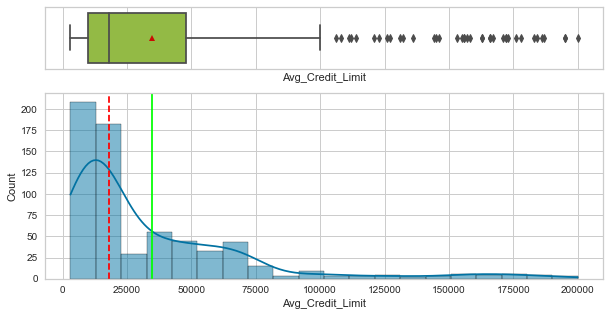

In [13]:
boxplot_hitogram(df, "Avg_Credit_Limit")

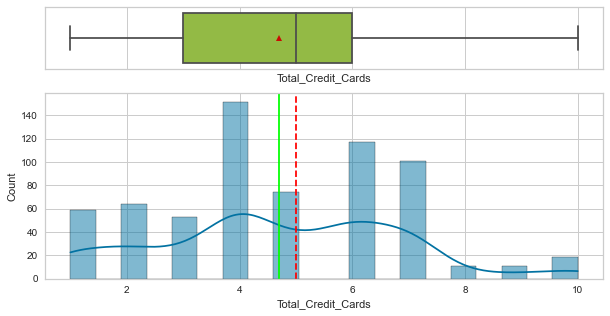

In [14]:
boxplot_hitogram(df, "Total_Credit_Cards")

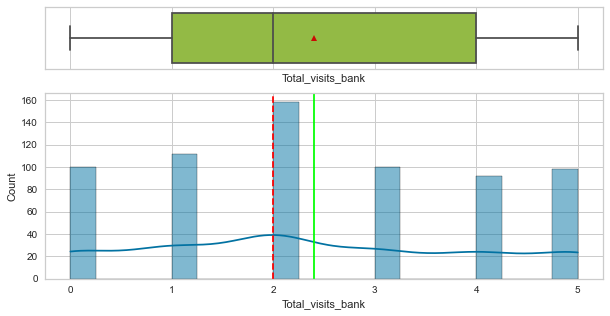

In [15]:
boxplot_hitogram(df, "Total_visits_bank")

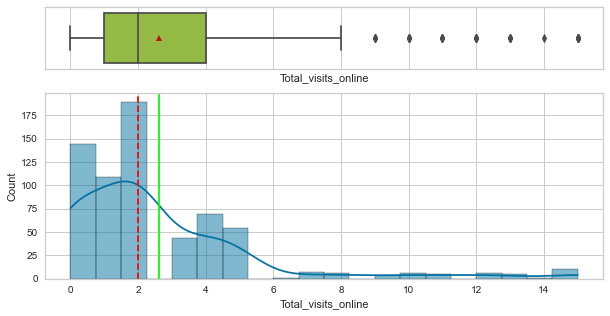

In [16]:
boxplot_hitogram(df, "Total_visits_online")

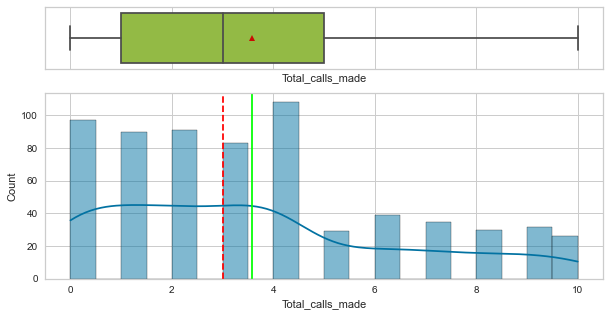

In [17]:
boxplot_hitogram(df, "Total_calls_made")

##### Observation

1) Avg_Credit_Limit, Total_calls_made, and Total_visits_online are right-skewed. 
2)  Total_visits_online and Avg_Credit_Limit have outliers.
3) The frequency of Credit card 4 values is higher than the other values' frequencies.
4) Two times, the customer's visits (yearly) to the bank are higher than the other times.
5) The max number of online logins made by the customer (yearly) is 15.
6) Some customers did not call the bank in a year.

### Bivariate Analysis

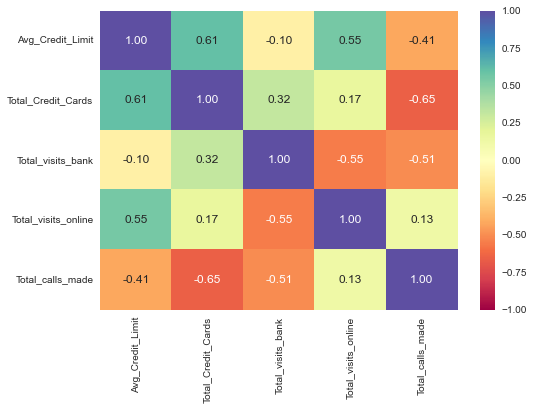

In [18]:
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

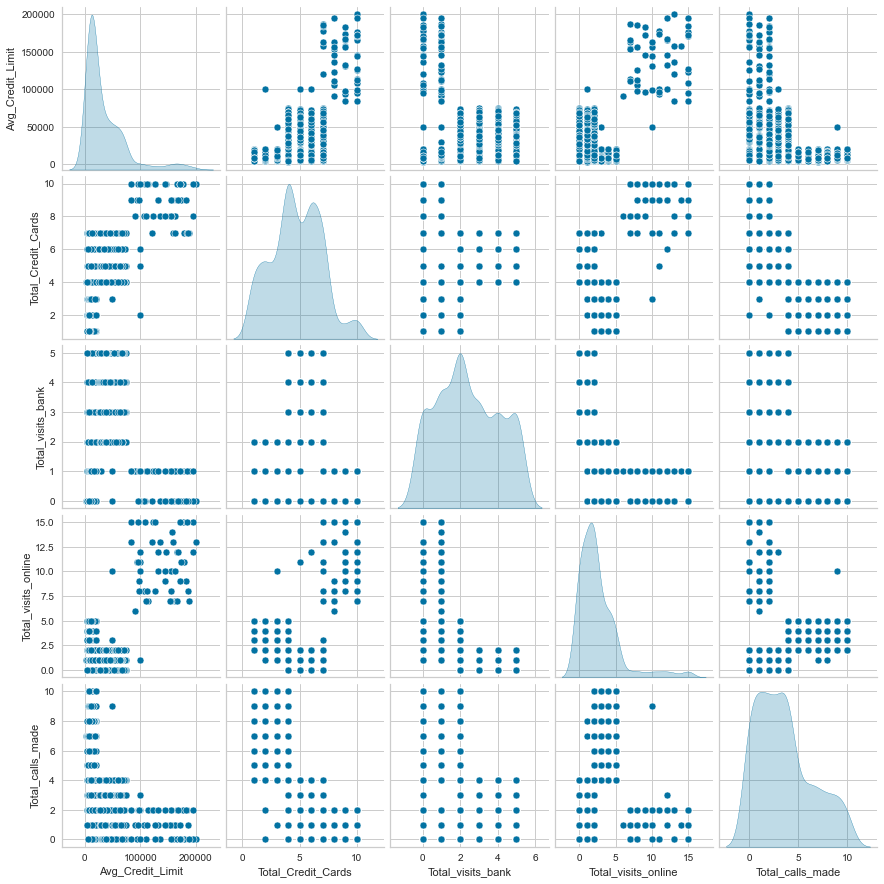

In [19]:
sns.pairplot(df, diag_kind="kde")

##### Observation

1) There is a moderate positive correlation between Avg_Credit_Limit and Total_Credit_Cards (r=0.61); Avg_Credit_Limit and Total_visits_online (r=0.55).
2) There is a moderate negative correlation between Total_Credit_Cards and Total_calls_made (r=-0.65); Total_visits_bank and Total_calls_made (r=-0.51); and Avg_Credit_Limit and Total_calls_made (r=-0.41).
3) Most of the calls to the bank are less than 5.


### Data Preprocessing

Scaling the dataset before clustering

In [20]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

In [21]:
scaled_df = pd.DataFrame(scaled, columns=df.columns) #creating a dataframe of the scaled columns

In [22]:
scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## K-means Clustering

C:\Users\kayaf\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429951888252041
Number of Clusters: 7 	Average Distortion: 0.9094949294930519
Number of Clusters: 8 	Average Distortion: 0.883335253931999
Number of Clusters: 9 	Average Distortion: 0.865970479262639
Number of Clusters: 10 	Average Distortion: 0.8413145933532743
Number of Clusters: 11 	Average Distortion: 0.8212596667938965
Number of Clusters: 12 	Average Distortion: 0.8019397867879047
Number of Clusters: 13 	Average Distortion: 0.7846712424115331
Number of Clusters: 14 	Average Distortion: 0.762888883985512


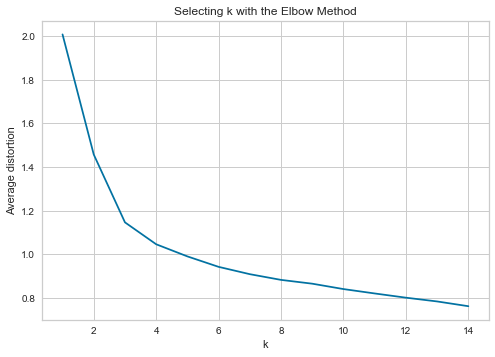

In [23]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model_k = KMeans(n_clusters=k)
    model_k.fit(scaled_df)
    prediction = model_k.predict(scaled_df)
    distortion = (
        sum(
            np.min(cdist(scaled_df, model_k.cluster_centers_, "euclidean"), axis=1)
        )
        / scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

Appropriate k can be 3 or 4 

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2726898791817692)
For n_clusters = 6, the silhouette score is 0.2558123746389958)
For n_clusters = 7, the silhouette score is 0.2486042710835614)
For n_clusters = 8, the silhouette score is 0.22686863628534076)
For n_clusters = 9, the silhouette score is 0.22544149692816112)


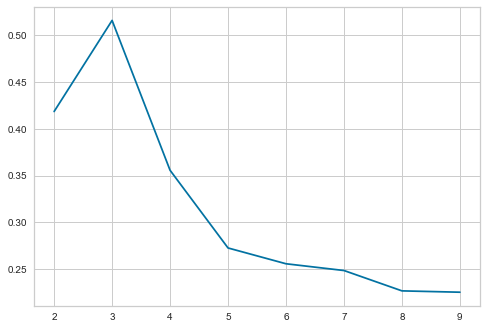

In [24]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((scaled_df))
    score = silhouette_score(scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Silhouette score for 3 is higher than the other values, so 3 is selected as a k

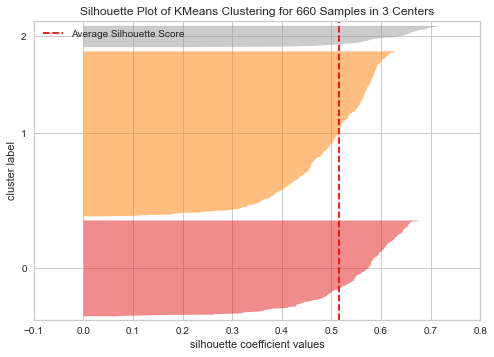

In [25]:
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

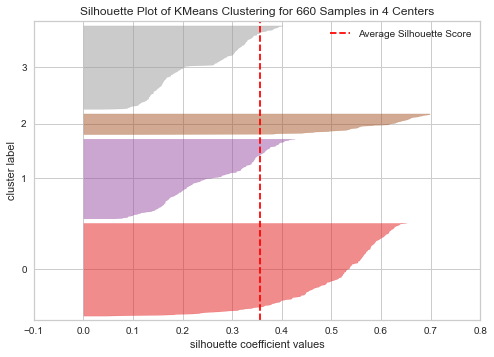

In [26]:
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

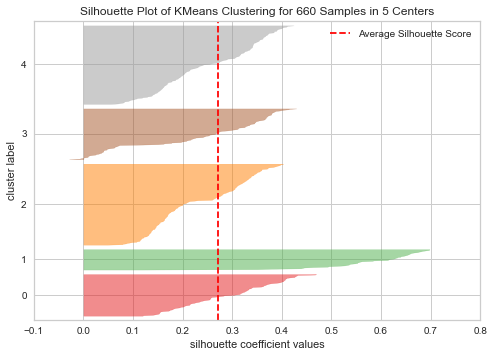

In [27]:
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

Low coefficient values in cluster 4 and cluster 5

In [28]:
model_kmeans = KMeans(n_clusters=3, random_state=0)
model_kmeans.fit(scaled_df)


KMeans(n_clusters=3, random_state=0)

#### Cluster Profiling

In [29]:
df["K_means_segments"] = model_kmeans.labels_


In [30]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,2


In [31]:
cluster_profile= df.groupby("K_means_segments").mean()
cluster_profile


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536
2,141040.000000,8.740000,0.600000,10.900000,1.080000


In [32]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Total_calls_made"].count().values
)

In [33]:
cluster_profile.style.highlight_max(color="pink", axis=0).highlight_min(color='lightblue')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


##### Observation

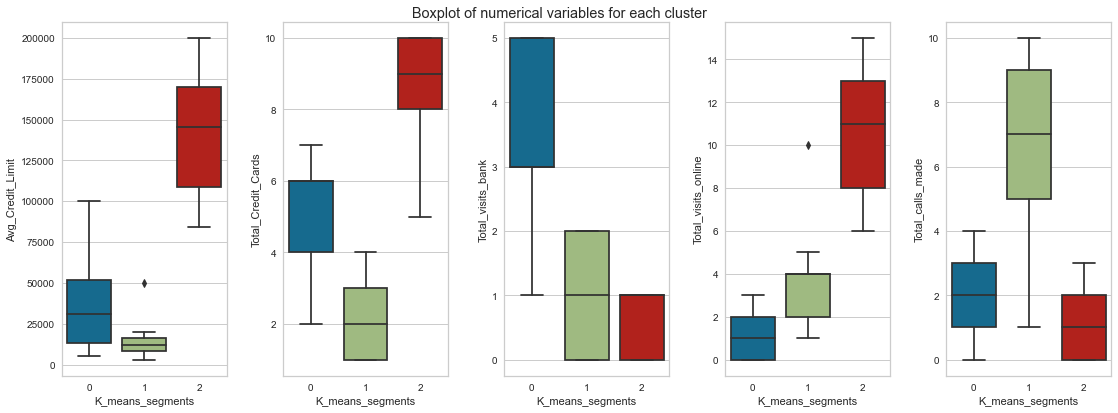

In [34]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<Figure size 1440x720 with 0 Axes>

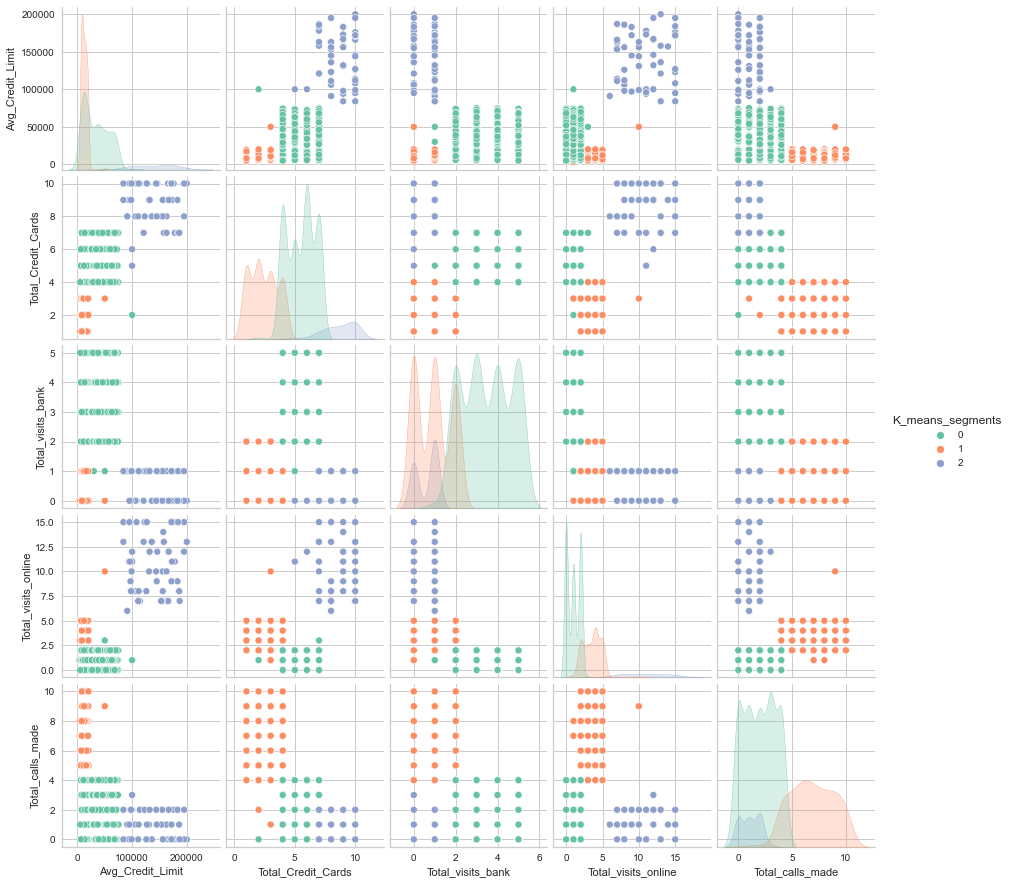

In [35]:
plt.figure(figsize=(20, 10))

sns.pairplot(df, diag_kind='kde', hue='K_means_segments',palette='Set2');

#### Insights

##### Cluster 0:

##### Cluster 1:

##### Cluster 2:

## Hierarchical Clustering

In [36]:
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock","jaccard"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

In [37]:
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


In [38]:
Z = linkage(scaled_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(scaled_df))

c

0.8977080867389372

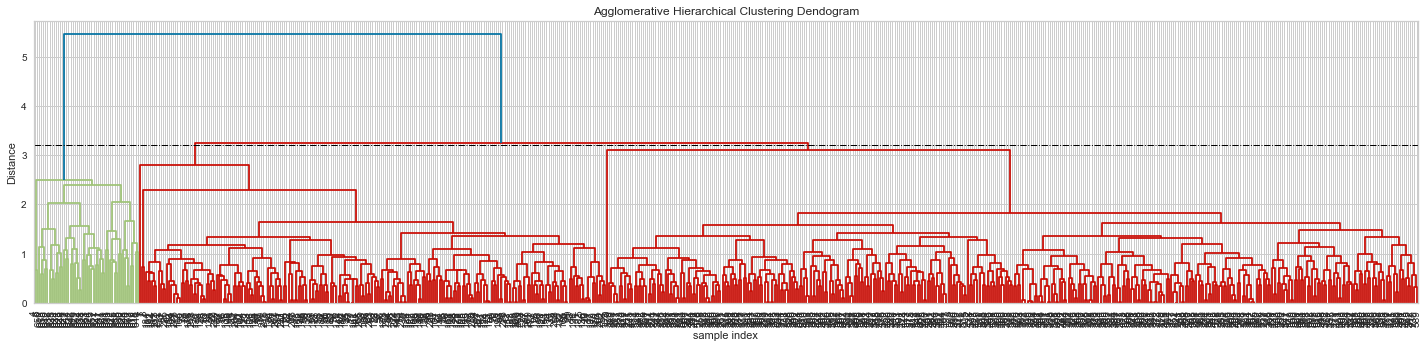

In [39]:
plt.figure(figsize=(20, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=10. )
plt.tight_layout()
plt.axhline(y=3.2, c="black", lw=1, linestyle="dashdot")

Let's check the euclidean distance and the ward linkage

In [40]:
Z = linkage(scaled_df, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(scaled_df))

c

0.7415156284827493

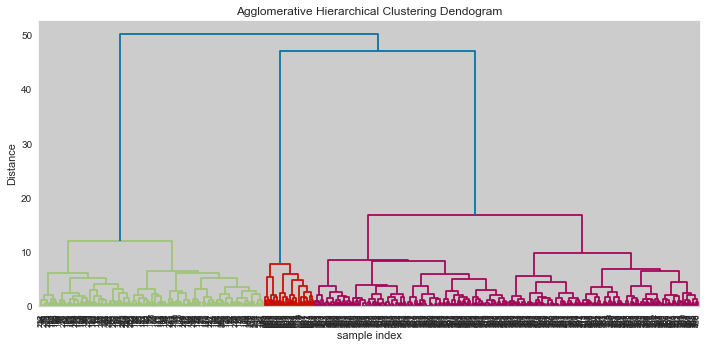

In [41]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8. )
plt.tight_layout() 

Let's check the euclidean distance and the centroid linkage

In [42]:
Z = linkage(scaled_df, metric='euclidean', method='centroid')
c, coph_dists = cophenet(Z , pdist(scaled_df))

c

0.8939385846326323

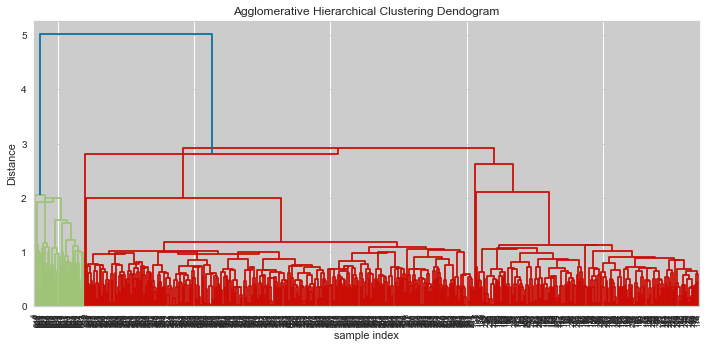

In [43]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8. )
plt.tight_layout() 

In [44]:
Z = linkage(scaled_df, metric='chebyshev', method='average')
c, coph_dists = cophenet(Z , pdist(scaled_df))

c

0.8974159511838106

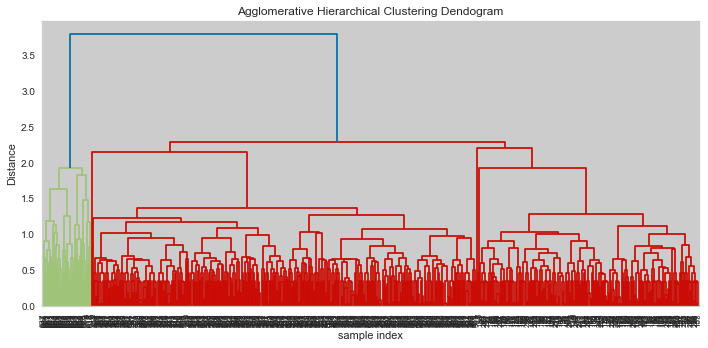

In [45]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8. )
plt.tight_layout() 

In [46]:
Z = linkage(scaled_df, metric='cityblock', method='average')
c, coph_dists = cophenet(Z , pdist(scaled_df))

c

0.896329431104133

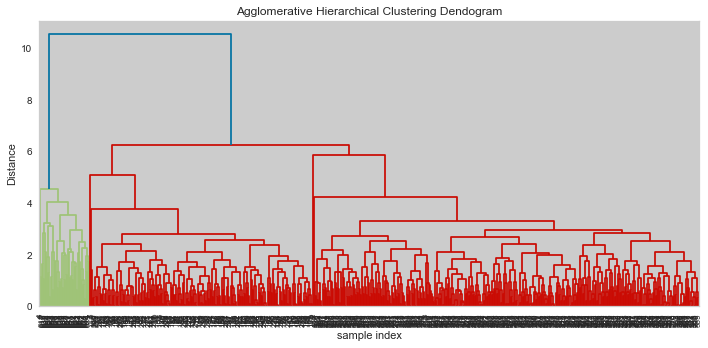

In [47]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,leaf_font_size=8. )
plt.tight_layout()

##### Observation

The cophenetic correlation is highest for the euclidean distance and average linkage, so we will move ahead with it. 3 (3.2 trashold) appears to be the appropriate number of clusters from the dendrogram for the avarage linkage.

In [48]:
model_h=AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')

In [49]:
model_h.fit(scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [50]:
df["Label"]=model_h.labels_

In [51]:
df.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,Label
0,100000,2,1,1,0,0,0
1,50000,3,0,10,9,1,2
2,50000,7,1,3,4,0,0
3,30000,5,1,1,4,0,0
4,100000,6,0,12,3,2,1
5,20000,3,0,1,8,1,2
6,100000,5,0,11,2,2,1
7,15000,3,0,1,1,1,2
8,5000,2,0,2,2,1,2
9,3000,4,0,1,7,1,2


#### Cluster Profiling

In [52]:
cluster_profile = df.groupby("Label").mean()
cluster_profile 

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
Label,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000


In [53]:
cluster_profile["count_each_segments_h"] = (
    df.groupby("Label")["Avg_Credit_Limit"].count().values
)
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_each_segments_h
Label,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223


In [54]:
cluster_profile.style.highlight_max(color="pink", axis=0).highlight_min(color="lightblue", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_each_segments_h
Label,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223


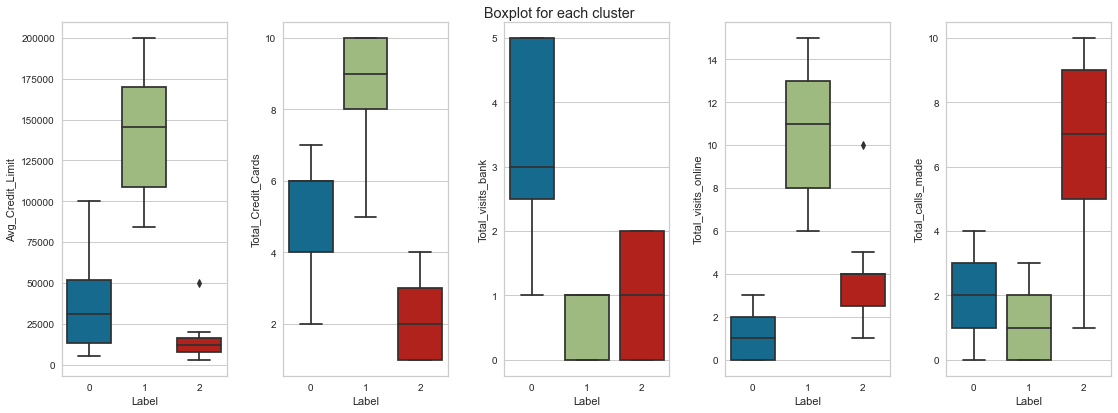

In [55]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["Label"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<Figure size 1440x720 with 0 Axes>

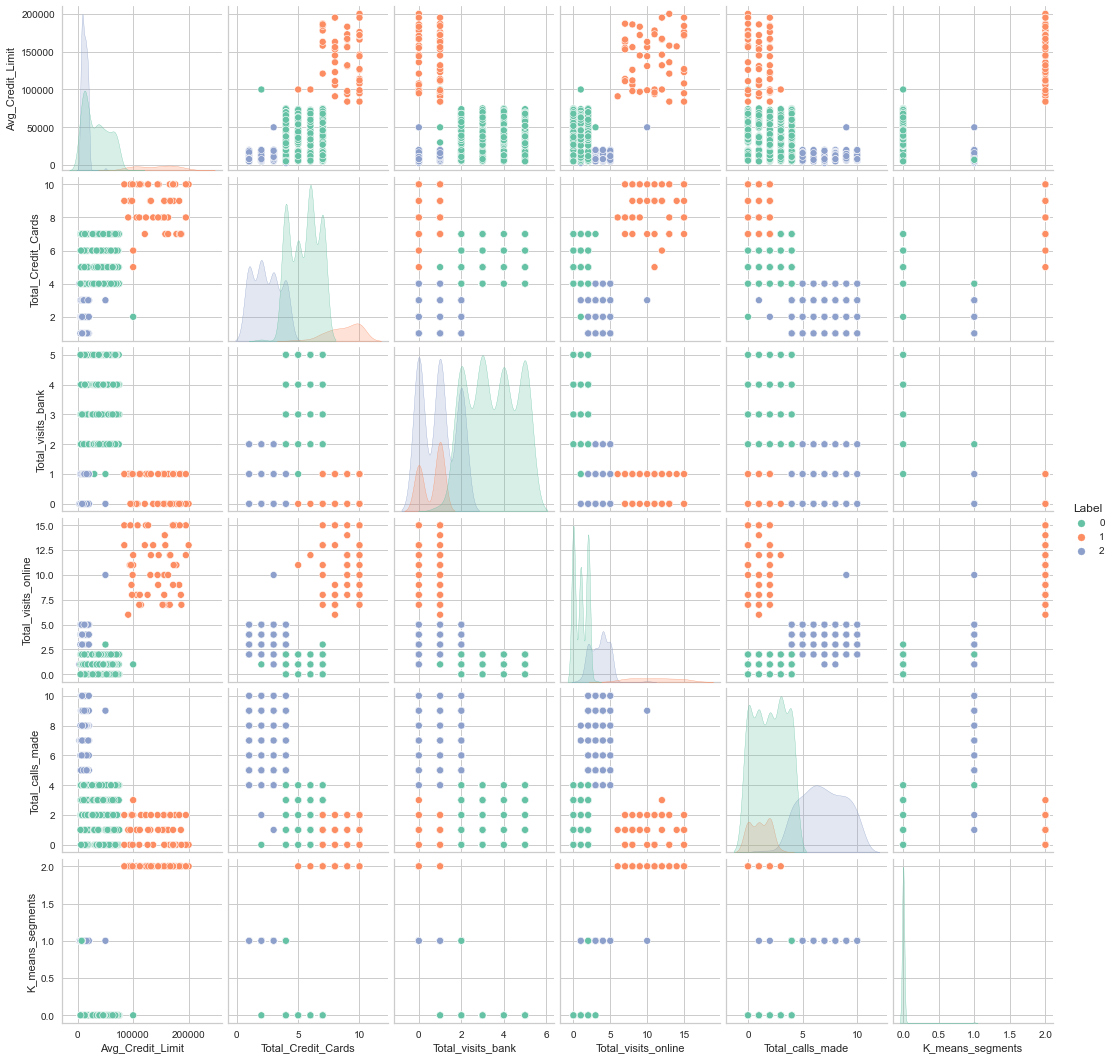

In [56]:
plt.figure(figsize=(20, 10))

sns.pairplot(df, diag_kind='kde', hue='Label',palette='Set2')

#### Insights

##### Cluster 0:

##### Cluster 1:

##### Cluster 2:

###### Compare clusters from K-means and Hierarchical Clustering and perform cluster profiling

# Actionable Insights & Recommendations

1) A group of customers use online banking and have a high number of credit cards and a high credit limit. The least number of customers are in this group. The bank may improve online banking to increase these types of customers. Also, the bank should inform new customers about online banking.
2) A group of customers who have a moderate number of credit cards and have a moderate credit limit visit the bank in person. The bank can reach these customers to inform them about online banking, which may increase the number of cards that the customers have.
3) A group of customers who prefer to contact the bank by phone has a low credit limit and a low number of credit cards. The bank can inform these customers about online banking. 
4) A bank may provide data about the customer's salary that would help the data scientist to explain why the customers have a low credit limit and a low number of credit cards.
